In [2]:
import sys
sys.path.append('src')
from src.trainer import EuroSATTrainer
from src.load_data import get_eurosat_dataloaders
from src.load_data import download_eurosat_data
import geopandas as gpd # for reading shapefiles
import folium  # library to create interactive maps
from shapely.geometry import MultiPolygon, Polygon
import os 
import rasterio as rio
from rasterio.mask import mask
import zipfile
import rasterio
import json
import shutil
import cv2
import numpy as np
from tqdm import tqdm
import torch
from collections import Counter

# read credentials.json
with open('credentials.json') as f:
    credentials = json.load(f)

import matplotlib.pyplot as plt
%matplotlib inline

# Next Steps

- Concat landmass types
- Repeat all processes below

In [4]:
# load model which standardizes input impages
best_model_path = 'src/nyc-sentinel-src/3ivihb0d/checkpoints/epoch=49-step=15249.ckpt'
model = EuroSATTrainer.load_from_checkpoint(best_model_path)

if torch.cuda.is_available():
    model.to('cuda:0');
    print("Model sent to cuda.")



Model sent to cuda.


# Comparision between 3 Rasters

The below code is for a spot-check esque analysis of 3 images from the same time,

In [107]:
# load rasters (downloaded through Sentinel Data Download Walkthrough.ipynb)
earliest_raster = rio.open('data/S2A_MSIL2A_20200706T153911_N0214_R011_T18TWL_20200706T201101.tiff').read()
latest_raster = rio.open('data/S2A_MSIL2A_20220825T155151_N0400_R011_T18TWL_20220825T220800.tiff').read()

In [108]:
# tiled image setup. Can only feed into model 3x64x64 inputs.
def crop_raster(raster,tile=64):
    tile = 64
    img_height = raster.shape[1]
    img_width = raster.shape[2]

    num_vertical_tiles = img_height // tile
    num_horizontal_tiles = img_width // tile
    return raster[:,:tile*num_vertical_tiles, :tile*num_horizontal_tiles]



In [109]:
cropped_latest_img = crop_raster(latest_raster)
cropped_earliest_img = crop_raster(earliest_raster)



In [110]:
# grab label dictionary
_, _, _, label_dict = get_eurosat_dataloaders(batch_size = 1, limit=1, test_size = .1)

100%|██████████| 1/1 [00:00<00:00, 3256.45it/s]


In [252]:


def get_tiled_predictions(cropped_img):

    tiled_array = np.zeros((cropped_img.shape[1],cropped_img.shape[2]))
    model.eval();
    tile_predictions = []
    tiled_images = []
    tiled_confidences = []
    tiled_indices = []
    with torch.no_grad():
        for i in tqdm(range(0, img_height-tile, tile)):
            for j in range(0, img_width-tile, tile):
                tiled_image = cropped_img[:,i:i+tile,j:j+tile]        
                if tiled_image.std() == 0:
                    tiled_array[i:i+tile,j:j+tile] = -1
                else:
                    x = torch.tensor(tiled_image.astype(np.int16))
                    x = (x - x.min()) / (x.max() - x.min())   
                    y_pred = model.forward(x.unsqueeze(0).cuda())
                    predicted_probs = y_pred.cpu().numpy()[0]
                    predicted_class = y_pred.argmax().cpu().item()
                    tiled_confidences.append(predicted_probs)
                    tiled_array[i:i+tile,j:j+tile] = predicted_class
                    tile_predictions.append(predicted_class)
                    tiled_images.append(tiled_image)
                    tiled_indices.append((i,j))

    return tile_predictions, tiled_array, tiled_images, tiled_confidences, tiled_indices

In [253]:
%%time 
# run inference on a sliding window for all tiles of both images.
latest_tile_predictions, latest_tiled_array, latest_tiled_images, latest_confidences, latest_tiled_indices = get_tiled_predictions(cropped_latest_img)
earliest_tile_predictions, earliest_tiled_array, earliest_tiled_images, earliest_confidences, earliest_tiled_indices = get_tiled_predictions(cropped_earliest_img)


100%|██████████| 35/35 [00:30<00:00,  1.16it/s]

CPU times: user 29.7 s, sys: 3.86 s, total: 33.6 s
Wall time: 59 s


In [254]:
from sklearn.metrics.pairwise import cosine_similarity

In [255]:
earliest_confidences = np.stack(earliest_confidences)
latest_confidences = np.stack(latest_confidences)

In [256]:
cos_sim = cosine_similarity(earliest_confidences,latest_confidences)

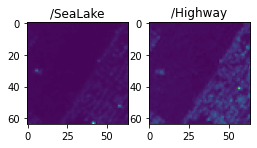

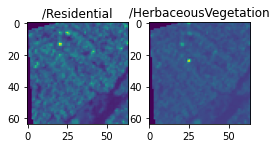

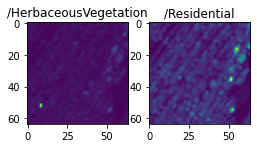

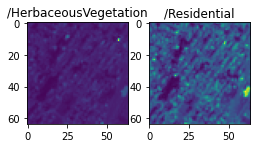

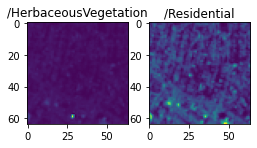

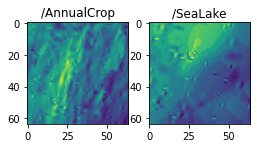

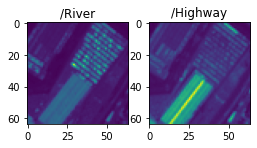

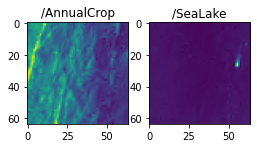

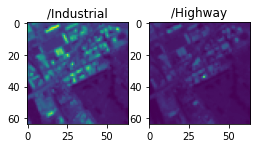

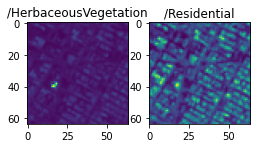

In [257]:
for i in range(cos_sim.shape[0]):
    for j in range(cos_sim.shape[1]):
        if i == j:
            if cos_sim[i][j] < .001:
                plt.figure(figsize=(4,8))
                plt.subplot(121)
                plt.title(label_dict[earliest_tile_predictions[i]])                
                plt.imshow(earliest_tiled_images[i][0])
                plt.subplot(122)
                plt.title(label_dict[latest_tile_predictions[i]])
                plt.imshow(latest_tiled_images[i][0])
                

Residential and herb are both patterns, but it's residential is brighter in comparison. 



In [ ]:
i = tile_prediction_pairs.index((6,3))

earliest_pred = earliest_tile_predictions[i]
latest_pred = latest_tile_predictions[i]
plt.figure(figsize = (6,3))
plt.subplot(121)
plt.imshow(earliest_tiled_images[i].mean(axis=0),cmap='gray')
plt.title(label_dict[earliest_pred].replace('/',''))
plt.subplot(122)
plt.imshow(latest_tiled_images[i].mean(axis=0),cmap='gray')
plt.title(label_dict[latest_pred].replace('/',''))


In [17]:
rasters = [f for f in os.listdir('data/') if f.endswith('.tiff')]

In [18]:
from datetime import datetime
import pandas as pd

In [46]:
def get_landmass_df(tile_predictions,date):
    tile_counter = Counter(tile_predictions)
    landmass_counts = {}
    for key in tile_counter.keys():
        landmass = label_dict[key].replace('/','')
        landmass_counts[landmass] = tile_counter[key]
        landmass_counts['date'] = date
    landmass_df = pd.DataFrame([landmass_counts])
    return landmass_df

In [47]:

landmass_change_df = pd.DataFrame()
for img in tqdm(rasters):
    # open image
    date = img.split('_')[2].split('T')[0]
    raster = rio.open(f'data/{img}').read()
    cropped_img = crop_raster(raster)
    tile_predictions, tiled_array, tiled_images = get_tiled_predictions(cropped_img)    
    year = date[:4]
    month = date[4:6]
    day = date[6:]
    date_str = f"{year}-{month}-{day}"
    date = datetime.strptime(date_str, '%Y-%m-%d')
    landmass_df = get_landmass_df(tile_predictions,date)
    landmass_change_df = landmass_change_df.append(landmass_df)

100%|██████████| 21/21 [08:53<00:00, 25.41s/it]


In [50]:
landmass_change_df['date'] = dates

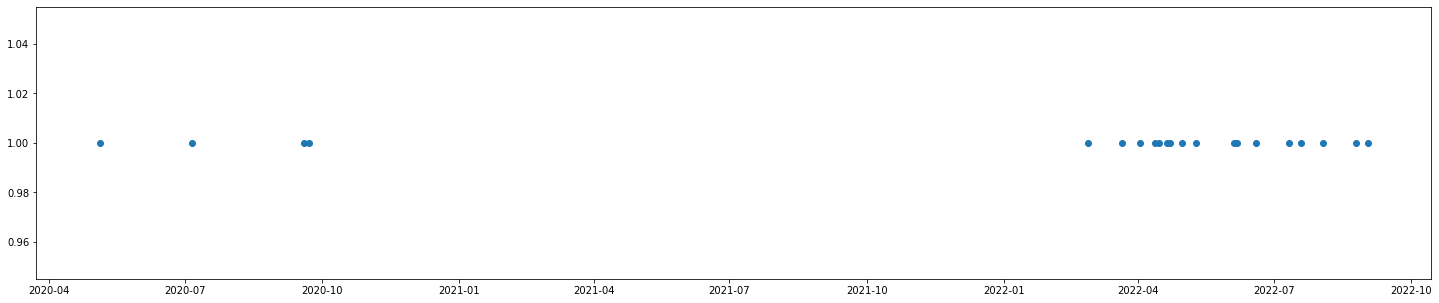

In [52]:
plt.figure(figsize=(25,5))
plt.plot(dates,[1 for x in dates],'o')

And from here can plot pct of a given crop type, and so on. 

<AxesSubplot:xlabel='date'>

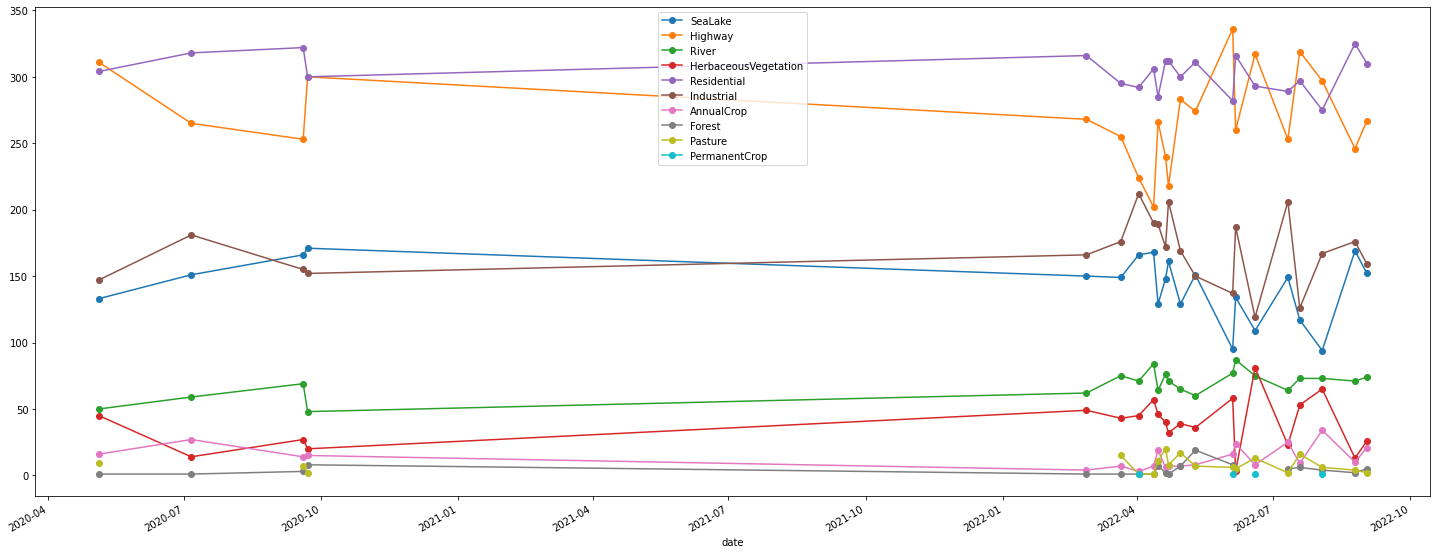

In [69]:
landmass_change_df.plot(x="date", y=['SeaLake', 'Highway', 'River', 'HerbaceousVegetation', 'Residential',
       'Industrial', 'AnnualCrop', 'Forest', 'Pasture', 'PermanentCrop'],marker = 'o',figsize=(25,10))

In [59]:
landmass_change_df.columns

Index(['SeaLake', 'Highway', 'River', 'HerbaceousVegetation', 'Residential',
       'Industrial', 'AnnualCrop', 'Forest', 'Pasture', 'PermanentCrop',
       'date'],
      dtype='object')